In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from IPython import display

%matplotlib inline

In [2]:
# Configurations
dataroot = "./data"

image_size = 128
workers=2
num_epochs = 200 #Full tests were done at 200 epochs
batch_size = 32
learning_rate = 1e-5
weight_decay = 1e-5

option = 'Ycbcr'

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), nb_channls, image_size, image_size)
    return x

device

device(type='cuda', index=0)

In [3]:
#Define conversions from RGB to YCbCr
# RGB [0,1] <-> YCbCr [0,1] in both cases
class RGB2YCbCr_Transform(object):
    def __call__(self,input):
      #Convert RGB image tensors in range[0,1] to YCbCr
     # input is a single image 3 x H x W 
      output = Variable(input.data.new(*input.size()))
      output[0, :, :] = input[0, :, :] *0.299 + input[1, :, :] *0.587 + input[2, :, :] *0.114 #Y in range [0, 1]
      output[1, :, :] = input[0, :, :] *(-0.168736) - input[1, :, :] *0.331264 + input[2, :, :] *0.5 +0.5 #Cb in range [0,1]
      output[2, :, :] = input[0, :, :] *0.5 - input[1, :, :] *0.418688 - input[2, :, :] *0.081312 +0.5 #Cr in range [0, 1]
      return output #output YCbCr all on range [0,1]

class YCbCr2RGB(object):
  def __call__(self, input):
    #Converts a denormalized YCbCr image Y [0,1] and Cb/Cr in range [0,1]
    #This operation is performed on the minibatches rather than individual images done in RGB2YCbCr_Transform
    output = Variable(input.data.new(*input.size()))
    output[:,0, :, :] = input[:,0, :, :] - (input[:,1, :, :] -0.5) *0.0009 + (input[:,2, :, :] -0.5) *1.4017  #R in range [0,1]
    output[:,1, :, :] = input[:,0, :, :] - (input[:,1, :, :] -0.5) *0.3437 - (input[:,2, :, :] -0.5) *0.7142 #G in range [0,1]
    output[:,2, :, :] = input[:,0, :, :] + (input[:,1, :, :]-0.5)*1.7722 + (input[:,2, :, :]-0.5) *0.0010 #B in range [0,1]
    return output


In [4]:
# Load Dataset
# Download Dataset
from torch.utils.data.sampler import SubsetRandomSampler
#Colour

print("USING YCbCr COLOUR IMAGES")
transform =transforms.Compose([transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               RGB2YCbCr_Transform()])
#Loading CIFAR-100

train_set = datasets.CIFAR100(root='./data',
                            train=True,
                            download=True, transform=transform
                           )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

test_set = datasets.CIFAR100(root='./data',
                            train=False,
                            download=True, transform=transform
                           )
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=workers)


USING YCbCr COLOUR IMAGES
Files already downloaded and verified
Files already downloaded and verified


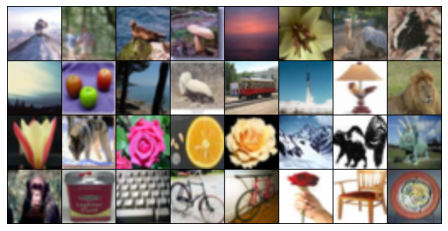

In [5]:
# Preview some images in dataset
convert = YCbCr2RGB()
batch = test_loader.__iter__().next()
batch[0] = convert(batch[0])

#Show one batch of test images 
plt.figure(figsize=(8,4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:

#Define Model -- Same architecture for all three components, however different networks will be used
#Model 1 
#Differences with Y Model compared to CbCr
class autoencoder_Y(nn.Module):
  def __init__(self,kernel_size1, kernel_size2):
    super(autoencoder_Y, self).__init__()
    self.component = 'Y'
    self.encoded = None
    #Input is one channel of Y -> Size 1x128x128
    self.downSample = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size1, padding=1, stride=1),
        nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size1, padding=1, stride=2),
        nn.PReLU()
    )
    self.fc = nn.Linear(in_features=1024, out_features=512)

    self.r_fc = nn.Linear(in_features=512, out_features=1024)
    self.upSample = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=kernel_size1, stride=1, padding=1),
        nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=kernel_size2, stride=2, padding=1),
        nn.PReLU()
    )
  def forward(self, x):
    #1) Encoder
    x = self.downSample(x)
    x = self.downSample(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fc(x)
    x = nn.Tanh()(x)
    self.encoded = x
    # 2) Decoder
    x = self.r_fc(x)
    x = nn.Tanh()(x)
    x = torch.reshape(x, (-1,1,32,32))
    x = self.upSample(x)
    x = self.upSample(x)
    x = nn.Tanh()(x)
    return x

class autoencoder_colour(nn.Module):
  def __init__(self,kernel_size1, kernel_size2):
    super(autoencoder_colour, self).__init__()
    self.component = 'CbCr'
    self.encoded = None
    #Input is two channels Cb and Cr -> Size 2x128x128
    self.downSample = nn.Sequential(
        nn.Conv2d(in_channels=2, out_channels=2, kernel_size=kernel_size1, padding=1, stride=1),
        nn.Conv2d(in_channels=2, out_channels=2, kernel_size=kernel_size1, padding=1, stride=2),
        nn.PReLU()
    )
    self.fc = nn.Linear(in_features=512, out_features=256)
    self.r_fc = nn.Linear(in_features=256, out_features=512)
    self.upSample = nn.Sequential(
        nn.ConvTranspose2d(in_channels=2, out_channels=2, kernel_size=kernel_size1, stride=1, padding=1),
        nn.ConvTranspose2d(in_channels=2, out_channels=2, kernel_size=kernel_size2, stride=2, padding=1),
        nn.PReLU()
    )
  def forward(self, x):
    #1) Encoder
    x = self.downSample(x)
    x = self.downSample(x)
    x = self.downSample(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fc(x)
    x = nn.Tanh()(x)
    self.encoded = x
    # 2) Decoder
    x = self.r_fc(x)
    x = nn.Tanh()(x)
    x = torch.reshape(x, (-1,2,16,16))
    x = self.upSample(x)
    x = self.upSample(x)
    x = self.upSample(x)
    x = nn.Tanh()(x)
    return x

In [7]:
# Compile Networks - Three seperate models for each channel in YCbCr
model_1 = autoencoder_Y((3,3), (4,4)).to(device)
model_2 = autoencoder_colour((3,3), (4,4)).to(device)
optimizer = torch.optim.Adam(
    model_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_2 = torch.optim.Adam(
    model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)

criterion = nn.MSELoss(reduction='mean')
summary(model_1, (1, image_size, image_size))
summary(model_2, (2, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 128, 128]              10
            Conv2d-2            [-1, 1, 64, 64]              10
             PReLU-3            [-1, 1, 64, 64]               1
            Conv2d-4            [-1, 1, 64, 64]              10
            Conv2d-5            [-1, 1, 32, 32]              10
             PReLU-6            [-1, 1, 32, 32]               1
            Linear-7                  [-1, 512]         524,800
            Linear-8                 [-1, 1024]         525,312
   ConvTranspose2d-9            [-1, 1, 32, 32]              10
  ConvTranspose2d-10            [-1, 1, 64, 64]              17
            PReLU-11            [-1, 1, 64, 64]               1
  ConvTranspose2d-12            [-1, 1, 64, 64]              10
  ConvTranspose2d-13          [-1, 1, 128, 128]              17
            PReLU-14          [-1, 1, 1

In [8]:
#Train three different identical networks on each Y Cb and Cr component
def train():
  #First try just training the Y
  iter = 0

  #Track Losses for each network and total
  epoch_lis = []
  loss_lis = []
  loss_colour_lis = []
  iteration=0
  for epoch in range(num_epochs):
      for data in train_loader:
          img, _ = data
          try:
            #-----Model #1 - Y COMPONENT--------
            model_1.train()
            y_component = img[:,0:1, :,:]
            y_component = Variable(y_component).to(device)
            # Forward
            output = model_1(y_component)
            loss = criterion(output, y_component)
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #-----Model #2 - Cb COMPONENT--------
            model_2.train()
            colour_components = img[:,1:3, :,:]
            colour_components = Variable(colour_components).to(device)
            # Forward
            output_colour = model_2(colour_components)
            loss_colour = criterion(output_colour, colour_components)

            # Backprop
            optimizer_2.zero_grad()
            loss_colour.backward()
            optimizer_2.step()
            #Every 50 iterations - update loss lists for graphing
            if iteration % 50 == 0:
                epoch_loss = (loss.item() + loss_colour)/2
                epoch_lis.append(epoch_loss)
                loss_lis.append(loss.item())
                loss_colour_lis.append(loss_colour.item())
            iteration += 1
          except:
            print("Error at iteration ", iteration)
            break
      print('epoch [{}/{}], loss:{:.8f},{:.8f}'
            .format(epoch + 1, num_epochs, loss.item(), loss_colour.item()))
  return epoch_lis, loss_lis, loss_colour_lis
        
      


In [9]:
#Plot losses
def plot_train_loss(epoch_lis, loss_lis=[], loss_colour_lis=[]):
  plt.plot(epoch_lis, label='Average loss')
  if option != 'grayscale':
    plt.plot(loss_lis, label='Y')
    plt.plot(loss_colour_lis, label ='Colour')

  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.show()


In [10]:
#Evaluate performance by printing images and comparing to the original
def evaluate():
  with torch.no_grad():
    m_batch_size = 4 #modified batch size for validation
    model_1.eval()
    model_2.eval()
    count = 0
    for data in test_loader:
      if count == 4: #only do first 16 images 
        break
      img, _ = data
      btch_list = reconstruct(img, m_batch_size)
      count += 1
      return btch_list

def reconstruct(test_img, m_batch_size):
  test_img = test_img[:m_batch_size] #take only the first four images of the batch
  #Y component
  y_comp = test_img[:,0:1,:,:]
  y_comp = Variable(y_comp).to(device)
  test_output_1 = model_1(y_comp)
  loss_1 = criterion(test_output_1, y_comp)
  if option != 'grayscale':
    #Colour component
    colour_comp = test_img[:,1:3,:,:]
    colour_comp = Variable(colour_comp).to(device)
    test_output_2 = model_2(colour_comp)
    loss_2 = criterion(test_output_2, colour_comp)

    print('loss:{:.8f},{:.8f}'
            .format(loss_1, loss_2))


    reconstructed = torch.empty(m_batch_size, 3, image_size, image_size) #reconstruct the 3 channels
    reconstructed[:,0:1,:,:] = test_output_1
    reconstructed[:,1:3,:,:] = test_output_2 #the stacked output of the three networks
    
    total_loss = criterion(reconstructed, test_img)
  else:
    #gray scale
    reconstructed = torch.empty(m_batch_size, 1, image_size, image_size) #reconstruct the grayscale channel
    reconstructed[:,0:1,:,:] = test_output_1

  # Preview some images and performance in the test set
  if option == 'Ycbcr':
    print("Formating for Ycbcr...")
    convert = YCbCr2RGB()
    test_img = convert(test_img)
    reconstructed = torch.clamp(reconstructed, -0.5, 1.0)
    reconstructed = convert(reconstructed)


  test_pic = reconstructed
  test_pic_orig = test_img
  btch_list = []
  ssim_mse = ''
  from skimage.metrics import structural_similarity as ssim
  from skimage.metrics import mean_squared_error

  label = 'MSE: {:.3f}, SSIM: {:.2f}  | '
  for i in range(test_pic.shape[0]):
    btch_list.append(test_pic_orig[i:i+1,:,:,:])
    btch_list.append((test_pic[i:i+1,:,:,:]))
    o_img = np.transpose(torch.reshape(test_pic_orig[i:i+1,:,:,:], (3,128,128)), (1,2,0)).numpy()
    r_img = np.transpose(torch.reshape(test_pic[i:i+1,:,:,:], (3,128,128)), (1,2,0)).numpy()
    ssim_res = ssim(o_img, r_img,data_range=r_img.max() - r_img.min(),multichannel=True)
    mse_res = mean_squared_error(o_img,r_img)
    ssim_mse += label.format(mse_res, ssim_res)
  btch = torch.cat(btch_list)
  fig = plt.figure( figsize=(8,1))
  btch = btch.to(device)[:8]
  ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2).cpu(),(1,2,0)))
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.axes.set_title(ssim_mse,fontdict={'fontsize': 9, 'fontweight': 'medium'})
  plt.show(fig)
  return btch_list

def mandrillTest(btch_list):
  #Test mandrill image SSIM to compare to variable compression paper
  from google.colab import drive
  from PIL import Image
  from skimage.metrics import structural_similarity as ssim
  from skimage.metrics import mean_squared_error

  drive.mount('/content/drive')
  with torch.no_grad():
    #Need to have mandriil.png image to run this
    image = Image.open("mandrill.png")
    image.show()
    #Code follows same process as reconstruct() function but with a single image
    t_image = transform(image)
    model_1.eval()
    model_2.eval()
    t_image = torch.reshape(t_image, (1,3,128,128))
    y_comp = t_image[:,0:1,:,:]
    y_comp = Variable(y_comp).to(device)
    test_output_1 = model_1(y_comp)
    colour_comp = t_image[:,1:3,:,:]
    colour_comp = Variable(colour_comp).to(device)
    test_output_2 = model_2(colour_comp)
    loss_2 = criterion(test_output_2, colour_comp)
    reconstructed = torch.empty(1, 3, image_size, image_size) #reconstruct the 3 channels
    reconstructed[:,0:1,:,:] = test_output_1
    reconstructed[:,1:3,:,:] = test_output_2 #the stacked output of the three networks
    convert = YCbCr2RGB()
    t_image = convert(t_image)
    reconstructed = torch.clamp(reconstructed, -0.5, 1.0)
    reconstructed = convert(reconstructed)
    test_pic = reconstructed
    test_pic_orig = t_image
    #Calculate SSIM, MSE
    ssim_mse = ''
    label = 'MSE: {:.3f}, SSIM: {:.2f}  | '
    btch_list.append(test_pic_orig[0:1,:,:,:])
    btch_list.append((test_pic[0:1,:,:,:]))
    o_img = np.transpose(torch.reshape(test_pic_orig[0:1,:,:,:], (3,128,128)), (1,2,0)).numpy()
    r_img = np.transpose(torch.reshape(test_pic[0:1,:,:,:], (3,128,128)), (1,2,0)).numpy()
    ssim_res = ssim(o_img, r_img,data_range=r_img.max() - r_img.min(),multichannel=True)
    mse_res = mean_squared_error(o_img,r_img)
    ssim_mse += label.format(mse_res, ssim_res)
    btch = torch.cat(btch_list)
    fig = plt.figure( figsize=(2,1))
    btch = btch.to(device)[-2:]
    ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2).cpu(),(1,2,0)))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_title(ssim_mse,fontdict={'fontsize': 9, 'fontweight': 'medium'})
    plt.show(fig)
    return btch_list

epoch [1/200], loss:0.26937279,0.26755548
epoch [2/200], loss:0.40357819,0.24052045
epoch [3/200], loss:0.31855172,0.10843925
epoch [4/200], loss:0.34966928,0.04731628
epoch [5/200], loss:0.21524091,0.03112120
epoch [6/200], loss:0.22431961,0.01952454
epoch [7/200], loss:0.12800850,0.01344387
epoch [8/200], loss:0.08572692,0.01307685
epoch [9/200], loss:0.11425217,0.01223752
epoch [10/200], loss:0.07286163,0.00829478
epoch [11/200], loss:0.06398371,0.00946818
epoch [12/200], loss:0.04110040,0.00816162
epoch [13/200], loss:0.04427588,0.00891299
epoch [14/200], loss:0.04146769,0.00822743
epoch [15/200], loss:0.03269456,0.00910894
epoch [16/200], loss:0.02863611,0.00714416
epoch [17/200], loss:0.02689678,0.00661176
epoch [18/200], loss:0.02743704,0.00607571
epoch [19/200], loss:0.02546905,0.00755761
epoch [20/200], loss:0.02511550,0.00653992
epoch [21/200], loss:0.01883286,0.00519064
epoch [22/200], loss:0.02081280,0.00364272
epoch [23/200], loss:0.01875383,0.00982937
epoch [24/200], loss

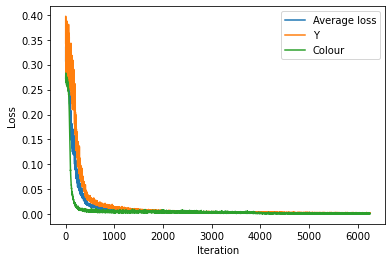

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss:0.00201188,0.00067941
Formating for Ycbcr...


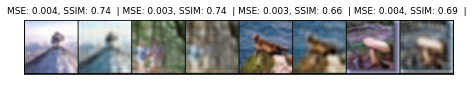

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


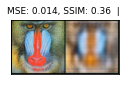

In [11]:
#This is the main function call
# - Runs the training and eval of the model
def test_model():
  model_1 = autoencoder_Y((3,3), (4,4)).to(device)
  model_2 = autoencoder_colour((3,3),(4,4)).to(device)
  optimizer = torch.optim.Adam(
      model_1.parameters(), lr=learning_rate, weight_decay=weight_decay)
  optimizer_2 = torch.optim.Adam(
      model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
  criterion = nn.MSELoss(reduction='mean')
  e_loss, l1, l2 = train()
  plot_train_loss(e_loss,loss_lis=l1,loss_colour_lis=l2)
  btch_list = evaluate()
  btch_list = mandrillTest(btch_list)
  return btch_list

btch_list = test_model()


In [12]:
#Calculate various metrics
#PSNR calculation on eval set
#Prints in order of the images from the cell above
import cv2
psnr_list = []
for i in range(0, len(btch_list), 2):
  #even ranges -> original, odd number -> reconstructed
  original = btch_list[i].numpy().reshape(3,image_size, image_size)
  original = np.transpose(original, (1,2,0))*255

  compressed = btch_list[i+1].numpy().reshape(3,image_size, image_size)
  compressed= np.transpose(compressed, (1,2,0))*255

  psnr = cv2.PSNR(compressed, original)
  psnr = round(psnr,2)
  psnr_list.append(psnr)

print(psnr_list)



[24.19, 25.94, 25.07, 24.11, 18.5]
